In [1]:
# Import necessary packages 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

## Load the data set 


In [2]:
# Oslobysykkel data
df = pd.read_csv('./sykk_data.csv')
df['year_day'] = df['year_day'].apply(pd.to_datetime)
#df.drop('Unnamed: 0', axis = 1, inplace=True)
#df['day'] = (df['date'].apply(pd.to_datetime)).dt.day

df.head()

,Unnamed: 0,year_day,start_station_id,n_trips
0,0,2019-04-02,401,1
1,1,2019-04-02,556,1
2,2,2019-04-02,561,1
3,3,2019-04-03,377,15
4,4,2019-04-03,378,26


In [3]:
# Weather data
w_df = pd.read_csv('./data/weather_daiy.csv')
w_df.rename(columns={'YEAR':'Year', 'MO':'Month', 'DY':'Day', 'HR':'Hour'}, inplace=True)
w_df['date'] = pd.to_datetime(w_df[['Year', 'Month', 'Day']], format = '%Y/%M/%D')
w_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
#
w_df = w_df[(w_df['date'] > '2019-04-01 00:00:00') & (w_df['date'] < '2022-03-01 00:00:00')]
w_df = w_df[~w_df['date'].between('2020-01-01 00:00:00', '2020-03-01 00:00:00')]

w_df.dtypes

temprature              float64
precipitation           float64
windspeed               float64
date             datetime64[ns]
dtype: object

## Merge the weather and Oslobysykkel data

In [4]:
# Merge the weather and no of trip data for initiated stations
merged = pd.merge(df, w_df, left_on='year_day', right_on='date', how='inner')
merged.drop('date', axis=1, inplace= True)
merged['day'] = merged['year_day'].dt.day
merged.to_csv('Sykkle_weather.csv')

def rain_or_not(x):
    if x > 0.35:
        return 'yes'
    else:
        return 'no'

merged['rain'] = merged['precipitation'].apply(rain_or_not)
#merged[merged['year_day']== '2021-08-28']

In [5]:
# Count the number of trips for rainy and dry days
rain_not = merged.groupby('rain')['n_trips'].sum().reset_index()
rain_not

,rain,n_trips
0,no,2425113
1,yes,2968383


<AxesSubplot:xlabel='rain', ylabel='count'>

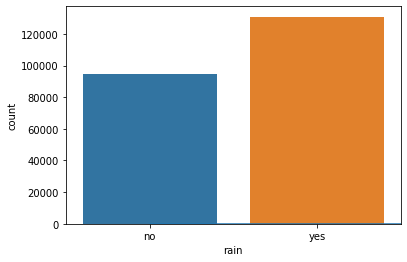

In [6]:
plt.plot(merged.precipitation)
#sns.barplot(x='rain', y = 'n_trips', data = merged, estimator= np.sum)
sns.countplot(x='rain', data=merged) # The number of males and females in the tips dataset

In [7]:
# 
df_tot_trip     = merged.groupby(['year_day']).agg({'n_trips':sum, 'temprature':'mean', 'precipitation':'mean', 'windspeed': 'mean'}).reset_index()#.sort_values('n_trips', ascending = False)
df_trip_station = merged.groupby(['start_station_id', 'year_day']).agg({'n_trips':sum, 'temprature':'mean', 'precipitation':'mean', 'windspeed': 'mean'}).reset_index()


In [8]:
#df_tot_trip = df_clean_tot[df_clean_tot['n_trips'] > 12]

In [9]:
#ls = [494, 398, 494, 421, 551]
#f, ax = plt.subplots(ncols = 2)

#station_589 = df_trip_station[(df_trip_station['start_station_id']==589) & (df_trip_station.n_trips>1)]

#ax[0].scatter(station_589.n_trips, station_589.windspeed)
#ax[1].scatter(df_tot_trip.n_trips, df_tot_trip.windspeed)
 
#station_589.head()   
#plt.show()

## Check if there is missing information


In [10]:
# sns.heatmap(df.isnull(), yticklabels= False, cbar = False)

# Handle the out liers 

In [11]:
def outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR    
    ls = df.index[ (df[feature] < lower_bound) | (df[feature] > upper_bound) ]    
    # Create a function that store the output indices from multiple columns     
    return ls

# Create a function that store the output indices from multiple columns 
def index_storage(df, features):
    index_ls = []
    for ft in features:
        ls = outliers(df, ft)
        index_ls.extend(ls)
    return index_ls

# define a function that removes the outliers 
def remove_outliers(df, ls):
    ls = sorted(set(ls)) # Unique index
    df = df.drop(ls)
    return df 

In [12]:
feature = ['n_trips', 'temprature', 'precipitation', 'windspeed']
index_tot = index_storage(df_tot_trip, feature)
index_station = index_storage(df_trip_station[df_trip_station['start_station_id'] == 494] , feature)

df_clean_tot = remove_outliers(df_tot_trip, index_tot) # Cleaned data set for total trip case per day
df_clean_sta = remove_outliers(df_trip_station[df_trip_station['start_station_id'] == 494], index_station)#.reset_index() # Cleaned data for each station per day 

In [13]:
df_clean_sta.tail()

,start_station_id,year_day,n_trips,temprature,precipitation,windspeed
101471,494,2021-09-06,57,12.90,0.16,1.55
101472,494,2021-09-07,64,14.69,0.16,1.64
101473,494,2021-09-08,106,16.44,0.11,1.61
101474,494,2021-09-09,89,16.06,0.07,0.91
101475,494,2021-09-10,24,15.45,0.76,1.62


In [15]:
#y_train = df_clean_sta.loc[100690:532+100690, 'n_trips'].values#.values
#print(max(y_train))
#print(y_train)
#y_test = df_clean_sta.loc[532+100690:, 'n_trips'].values
#print(max(y_test)) 



# Data visualization 

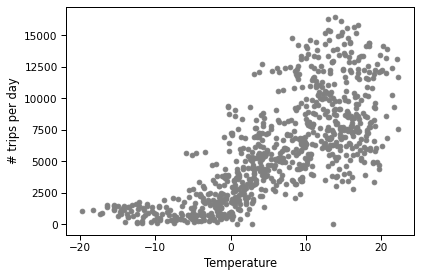

In [16]:
# Plot 
#plt.scatter(df_clean_tot.temprature, df_clean_tot.n_trips)

sns.set_context('paper', font_scale=1.2)
plt.scatter(df_clean_tot.temprature, df_clean_tot.n_trips, color = 'grey')
plt.xlabel('Temperature')
plt.ylabel('# trips per day')
plt.tight_layout()
#plt.set(frame_on = False)
plt.savefig('/home/abay/Desktop/DataScienceTutor/sykk/images/total_number_per_temp.eps')

#sns.jointplot(data = df_clean_sta , y = 'n_trips', x = 'temprature', kind='reg')
#sns.jointplot(data = df_clean_tot, x = 'n_trips', y = 'precipitation', kind='reg')

<Figure size 720x576 with 0 Axes>

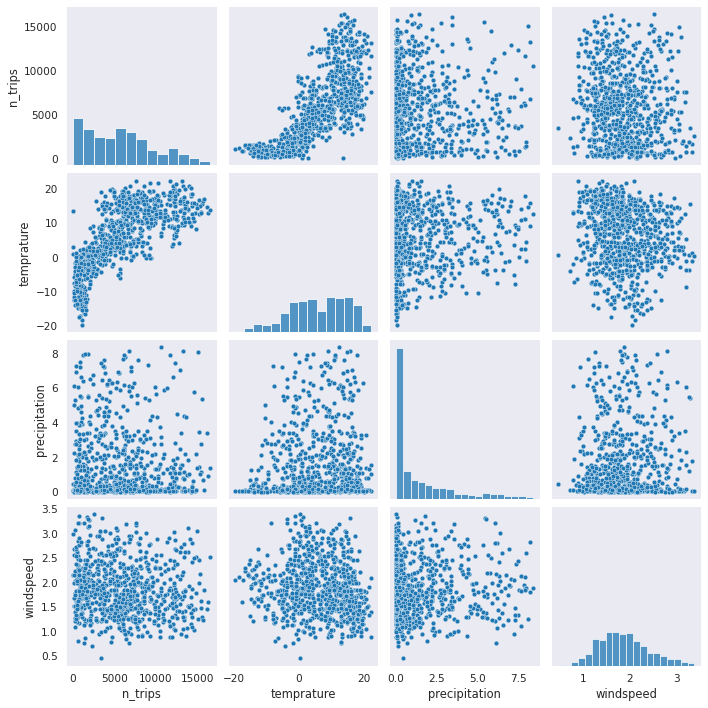

<Figure size 432x288 with 0 Axes>

In [17]:
sns.set_style('dark')
plt.figure(figsize=(10,8))

sns.pairplot(df_clean_tot)
plt.show()
plt.savefig('/home/abay/Desktop/DataScienceTutor/sykk/images/Pair_plot_for_weather_sykkle_data.eps')

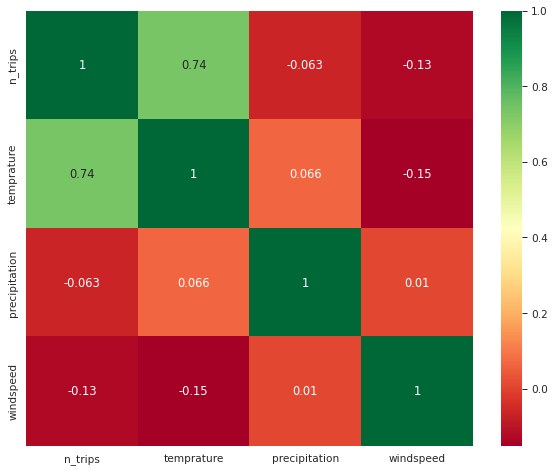

In [18]:
# Correlation between attributes

corr = df_clean_tot.corr()
top_corr_features = corr.index # index for correlated features 
plt.figure(figsize=(10,8))
heatmap_plot = sns.heatmap(df_clean_tot[top_corr_features].corr(), annot = True, cmap = 'RdYlGn')
plt.savefig('/home/abay/Desktop/DataScienceTutor/sykk/images/correlation_weathervsntrips.eps')

# Predictive modeling

## Predict total number of trips for a given weather information

In [19]:
# Xgboost regression
import xgboost
from sklearn.model_selection import RandomizedSearchCV # Used to choose best parameters 
def xgb_regressor():
    regressor = xgboost.XGBRegressor()

    booster = ['gbtree', 'gblinear']
    base_score = [0.25 ,0.5, 0.75, 1]
    n_estimators = [50, 100, 500, 1000, 1500]
    max_depth = [4,5, 6, 8, 10]
    learning_rate = [0.05, 0.1, 0.15, 0.2]
    min_child_weight = [1,2,3,4]
    
    # Define the grid of hyperparameters to search
    hyper_para_grid = {
        'n_estimators':n_estimators,
        'max_depth': max_depth,
        'learning_rate': min_child_weight,
        'booster':booster,
        'base_score':base_score
    }
    #set up the random search with 4-fold cross validation 
    rand_cv = RandomizedSearchCV(estimator = regressor,
                                 param_distributions = hyper_para_grid,
                                 cv=5, n_iter=50,
                                 scoring = 'neg_mean_absolute_error',
                                 
                                 n_jobs = 4,
                                 verbose= 5,
                                 return_train_score = True,
                                 random_state = 42
                                )
    return rand_cv
rand_cv = xgb_regressor()

In [20]:
#rand_cv.fit(x_train, y_train)
#rand_cv.best_estimator_

## Prepare the data set for prediction

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

scalar = StandardScaler()# MinMaxScaler(feature_range=(0,1))
x_train = df_clean_tot.loc[0:662, ['temprature', 'precipitation', 'windspeed']].values
x_test  = df_clean_tot.loc[662:, ['temprature', 'precipitation', 'windspeed']].values

#x_train = scalar.fit_transform(x_train)
#x_test = scalar.fit_transform(x_test)

y_train = df_clean_tot.loc[0:662, 'n_trips'].values
y_test = df_clean_tot.loc[662:, 'n_trips'].values

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) 
# x_train = xgb.DMatrix(x_train, label=y_train)
# x_test  = xgb.DMatrix(x_test, label=y_test)

y_train = scalar.fit_transform(y_train.reshape(-1,1))
y_test  = scalar.fit_transform(y_test.reshape(-1,1))

In [22]:
regressor = xgboost.XGBRegressor(base_score=1, booster='gblinear',
             enable_categorical=False, gpu_id=-1, learning_rate=1, max_depth=10,
             min_child_weight=None, monotone_constraints=None,
             n_estimators=100, n_jobs=4, num_parallel_tree=None, predictor=None,
             random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)
regressor.fit(x_train, y_train)



[16:08:32] WARNING: ../src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=1, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=1, max_delta_step=None, max_depth=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=4, num_parallel_tree=None, predictor=None,
             random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

In [23]:
ypredict = regressor.predict(x_train)

#rmse = np.sqrt(MSE(y_train, ypredict))
#print("RMSE : % f" %(rmse))

print('r score: % f' %(r2_score(y_train, ypredict) ))

r score:  0.614339


In [24]:
regressor = xgboost.XGBRegressor(booster='gblinear',
                                 learning_rate = 0.5, 
                                 max_depth = 6, 
                                 n_estimators=1000
                                 )
regressor.fit(x_train, y_train)

[16:08:34] WARNING: ../src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=6,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=4, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=1, verbosity=None)

In [25]:
ypredict = regressor.predict(x_train)

#rmse = np.sqrt(MSE(y_train, ypredict))
#print("RMSE : % f" %(rmse))

print('r score: % f' %( r2_score(y_train, ypredict) ))

r score:  0.614339


# Random forest regressor


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error as MSE

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 100)# Train the model on training data

x_train = df_clean_tot.loc[0:662, ['temprature', 'precipitation', 'windspeed']].values
x_test  = df_clean_tot.loc[662:,  ['temprature', 'precipitation',  'windspeed']].values

#x_train = scalar.fit_transform(x_train)
#x_test = scalar.fit_transform(x_test)

y_train = df_clean_tot.loc[0:662, 'n_trips'].values
y_test  = df_clean_tot.loc[662:,  'n_trips'].values

y_train = scalar.fit_transform(y_train.reshape(-1, 1))
y_test  = scalar.fit_transform(y_test.reshape(-1, 1))

rf.fit(x_train, y_train);

/home/abay/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [27]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_train)# Calculate the absolute errors
r2_score(predictions, y_train)

0.94145878214308

# K-nearest neighbor regression

In [30]:
#K-nearest neighbor regression

from sklearn.neighbors import KNeighborsRegressor
x = df_clean_tot[['temprature', 'precipitation', 'windspeed']]
y = df_clean_tot['n_trips']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)# instantiate the model and set the number of neighbors to consider to 3

x_train = df_clean_tot.loc[0:662, ['temprature', 'precipitation', 'windspeed']].values
x_test  = df_clean_tot.loc[662:,  ['temprature', 'precipitation', 'windspeed']].values

#x_train = scalar.fit_transform(x_train)
#x_test = scalar.fit_transform(x_test)

y_train = df_clean_tot.loc[0:662, 'n_trips'].values
y_test = df_clean_tot.loc[662:, 'n_trips'].values

y_train = scalar.fit_transform(y_train.reshape(-1,1))
y_test = scalar.fit_transform(y_test.reshape(-1,1))

knn_reg = KNeighborsRegressor(n_neighbors = 5)# fit the model using the training data and training targets
knn_reg.fit(x_train, y_train)

predict = knn_reg.predict(x_train)#.reshape(-1,1)


print('Knn score :%f' %(r2_score(y_train, predict))) 

Knn score :0.748458


# Visualization for KNN

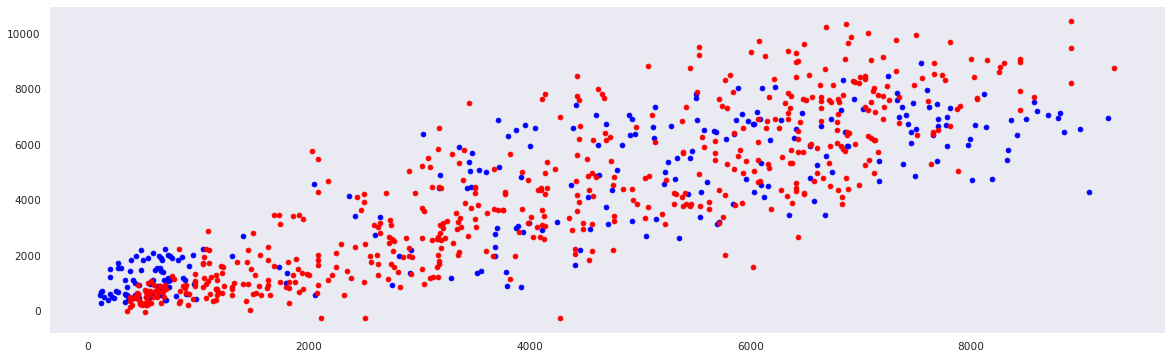

In [31]:
y_train_pred = scalar.inverse_transform( knn_reg.predict(x_train).reshape(-1,1) )
y_test_pred = scalar.inverse_transform( knn_reg.predict(x_test).reshape(-1,1) )

y_test_actual = scalar.inverse_transform( y_test )
y_train_actual = scalar.inverse_transform( y_train )

plt.figure(figsize=(20,6))
plt.scatter(y_test_actual, y_test_pred, color='blue')
plt.scatter(y_train_pred, y_train_actual, color = 'red')


# Ensemble method

In [32]:
# importing utility modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb

 
# importing bagging module
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

 
# Splitting between train data into training and validation dataset
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape)

x_train = df_clean_tot.loc[0:662, ['temprature', 'precipitation', 'windspeed']].values
x_test  = df_clean_tot.loc[662:, ['temprature',  'precipitation', 'windspeed']].values


y_train = df_clean_tot.loc[0:662, 'n_trips'].values
y_test = df_clean_tot.loc[662:, 'n_trips'].values

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#import xgboost as xgb

#x_train = xgb.DMatrix(x_train, label=y_train)
#_test = xgb.DMatrix(x_test, label=y_test)

y_train = scalar.fit_transform(y_train.reshape(-1,1))
y_test  = scalar.fit_transform(y_test.reshape(-1,1))


# initializing the bagging model using XGboost as base model with default parameters
ensemble = BaggingRegressor(base_estimator=RandomForestRegressor())
 
# training model
ensemble.fit(x_train, y_train)
 
# predicting the output on the test dataset
# printing the root mean squared error between real value and predicted value
# print(mean_squared_error(y_train, pred))

(560, 3)


/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingRegressor(base_estimator=RandomForestRegressor())

In [33]:
# R2 score

pred = ensemble.predict(x_test)
r2_score(y_test, pred)

0.7436290620111948

# Visualization for Ensemble method

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


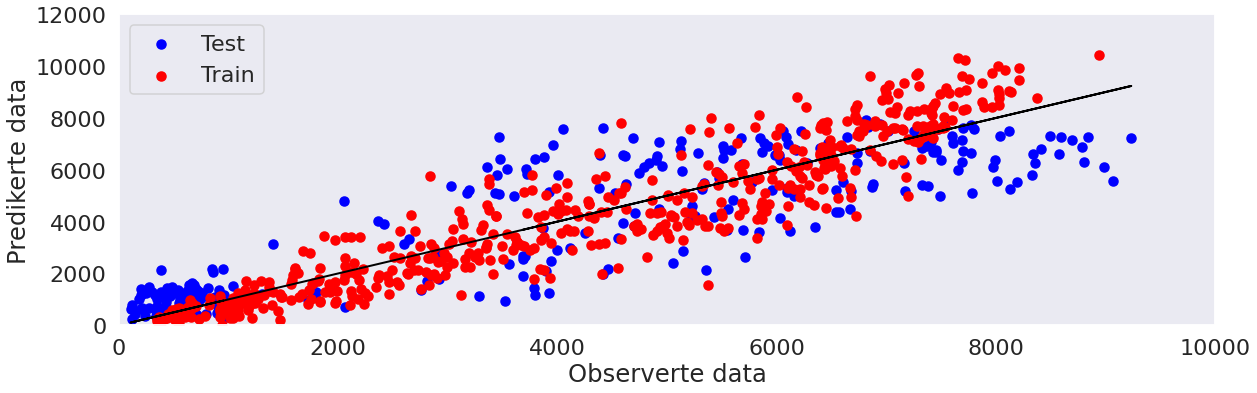

In [34]:
y_train_pred = scalar.inverse_transform( ensemble.predict(x_train).reshape(-1,1) )
y_test_pred = scalar.inverse_transform( ensemble.predict(x_test).reshape(-1,1) )

y_test_actual = scalar.inverse_transform( y_test )
y_train_actual = scalar.inverse_transform( y_train )

#y_test_pred = scalar.inverse_transform( knn_reg.predict(x_test).reshape(-1,1) )

sns.set_context('talk', font_scale=1.350)
f, ax = plt.subplots(figsize=(18,6))
#axt = ax.twinx()
ax.scatter(y_test_actual, y_test_pred, color='blue')
ax.scatter(y_train_pred, y_train_actual, color = 'red')
ax.legend(['Test','Train'], loc='upper left')

ax.plot(y_test_actual, y_test_actual, '-k', linewidth = 2)
ax.set_ylim(0, 12000)
ax.set_xlim(0, 10000)

ax.set_xlabel("Observerte data")
ax.set_ylabel("Predikerte data")
ax.set(frame_on=True)
f.tight_layout()
f.savefig('/home/abay/Desktop/DataScienceTutor/sykk/images/total_no_trips_prediction.eps')

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
# Splitting between train data into training and validation dataset
#X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.20)
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor()
 
# training the model on the train dataset
model.fit(x_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(x_test)
# printing the root mean squared error between real value and predicted value
#print(mean_squared_error(y_train, pred_final))

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [36]:
r2_score(pred_final, y_test)

0.7009617599865714

# Start stations 

In [37]:
# The most busiest station 
df_clean_sta.shape[0]*0.8
station_494 = df_clean_sta
station_494.head()
#sns.pairplot(station_494[['n_trips', 'temprature', 'windspeed', 'precipitation']])

,start_station_id,year_day,n_trips,temprature,precipitation,windspeed
100690,494,2019-04-03,64,1.97,0.68,1.73
100691,494,2019-04-04,123,4.32,0.03,1.95
100692,494,2019-04-05,128,3.32,0.41,2.26
100693,494,2019-04-06,107,3.15,0.26,1.07
100694,494,2019-04-07,95,2.80,0.03,2.62


## Ensemble method 


In [38]:
# importing utility modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb

 
# importing bagging module
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

 
# Splitting between train data into training and validation dataset
x, y = station_494[['temprature', 'precipitation', 'windspeed']].values, station_494['n_trips'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0, shuffle=True)
#print(x_train.shape)

x_train = station_494.loc[0:532+100690, ['temprature', 'precipitation', 'windspeed']].values
x_test  = station_494.loc[532+100690:, ['temprature', 'precipitation', 'windspeed']].values


y_train = station_494.loc[0:532+100690, 'n_trips'].values#.values
#print(y_train)
y_test = station_494.loc[532+100690:, 'n_trips'].values

y_train = scalar.fit_transform(y_train.reshape(-1,1))
y_test  = scalar.fit_transform(y_test.reshape(-1,1))

# initializing the bagging model using XGboost as base model with default parameters
ensemble = BaggingRegressor(base_estimator=RandomForestRegressor())
 
# training model
ensemble.fit(x_train, y_train)
 
# predicting the output on the test dataset
# printing the root mean squared error between real value and predicted value
#print(mean_squared_error(y_train, pred))

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingRegressor(base_estimator=RandomForestRegressor())

In [39]:
predict = ensemble.predict(x_train)
r2_score(predict, y_train)

0.7864105264030573

# Random Forest for single station

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scalar = StandardScaler()
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)# Train the model on training data

#x_train = df_clean_tot.loc[0:650, ['temprature', 'precipitation', 'windspeed']]
#x_test  = df_clean_tot.loc[650:, ['temprature', 'precipitation', 'windspeed']]
#y_train = df_clean_tot.loc[0:650, 'n_trips'].values
#y_test = df_clean_tot.loc[650:, 'n_trips'].values
x_train = station_494.loc[0:100690+532, ['temprature', 'precipitation', 'windspeed']].values
#print(x_train)
x_test  = station_494.loc[532+100690:, ['temprature', 'precipitation', 'windspeed']].values


y_train = station_494.loc[100690:532+100690, 'n_trips'].values#.values
#print(y_train)
y_test = station_494.loc[532+100690:, 'n_trips'].values

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#import xgboost as xgb

#x_train = xgb.DMatrix(x_train, label=y_train)
#x_test = xgb.DMatrix(x_test, label=y_test)


y_train = scalar.fit_transform(y_train.reshape(-1, 1))
y_test  = scalar.fit_transform(y_test.reshape(-1, 1))

rf.fit(x_train, y_train)

/home/abay/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(n_estimators=1000, random_state=0)

In [41]:
predict = rf.predict(x_test)
r2_score(predict, y_test)

0.8043532283836426

# Visualization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


147.0
138.22755510068427


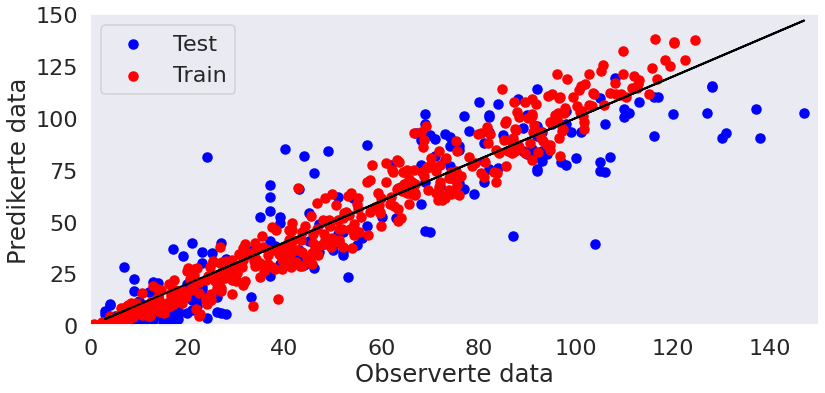

In [42]:
y_train_pred = scalar.inverse_transform( rf.predict(x_train).reshape(-1,1) )
y_test_pred = scalar.inverse_transform( rf.predict(x_test).reshape(-1,1) )

y_test_actual  = scalar.inverse_transform( y_test )
y_train_actual = scalar.inverse_transform( y_train )

rescaled_ytest = scalar.inverse_transform(y_test)
rescaled_ytrain = scalar.inverse_transform(y_train)

print(np.max( rescaled_ytest) )
print(np.max( rescaled_ytrain) )
#y_test_pred = scalar.inverse_transform( knn_reg.predict(x_test).reshape(-1,1) )

sns.set_context('talk', font_scale=1.350)
f, ax = plt.subplots(figsize=(12, 6))
#axt = ax.twinx()
ax.scatter(y_test_actual, y_test_pred, color='blue')
ax.scatter(y_train_pred, y_train_actual, color = 'red')
ax.legend(['Test', 'Train'], loc='upper left')

ax.plot(y_test_actual, y_test_actual, '-k', linewidth = 2)
ax.set_ylim(0, 150)
ax.set_xlim(0, 150)

ax.set_xlabel("Observerte data")
ax.set_ylabel("Predikerte data")
ax.set(frame_on=True)
f.tight_layout()
f.savefig('/home/abay/Desktop/DataScienceTutor/sykk/images/station_496_no_trips_prediction.eps')

# K-nearest neighbor regression


In [43]:

from sklearn.neighbors import KNeighborsRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)# instantiate the model and set the number of neighbors to consider to 3

x_train = station_494.loc[0:532+100690, ['temprature', 'precipitation', 'windspeed']].values
x_test  = station_494.loc[532+100690:, ['temprature', 'precipitation', 'windspeed']].values


y_train = station_494.loc[0:532+100690, 'n_trips'].values#.values
#print(y_train)
y_test = station_494.loc[532+100690:, 'n_trips'].values

y_train = scalar.fit_transform(y_train.reshape(-1,1))
y_test = scalar.fit_transform(y_test.reshape(-1,1))

knn_reg = KNeighborsRegressor(n_neighbors = 5)# fit the model using the training data and training targets
knn_reg.fit(x_train, y_train)


 

KNeighborsRegressor()

In [44]:
predict = knn_reg.predict(x_train)#.reshape(-1,1)
print('Knn score :%f' %(r2_score(y_train, predict)))


Knn score :0.700955


# Number of return trips per  station 


In [45]:
df_end = pd.read_csv('./data/end_station_sykkle_data.csv')
df_end['year_day'] = df_end['year_day'].apply(pd.to_datetime)

df_end.head()

,Unnamed: 0,year_day,end_station_id,n_trips
0,0,2019-04-02,381,1
1,1,2019-04-02,471,1
2,2,2019-04-02,556,1
3,3,2019-04-03,377,12
4,4,2019-04-03,378,17


In [46]:
merged_end = pd.merge(df_end, w_df, left_on='year_day', right_on='date', how='inner')
df_trip_end_station = merged_end.groupby(['end_station_id', 'year_day']).agg({'n_trips':sum, 'temprature':'mean', 'precipitation':'mean', 'windspeed': 'mean'}).reset_index()

#df_trip_end_station[df_trip_end_station['year_day']== '2021-08-28']

In [54]:
feature = ['n_trips', 'temprature', 'precipitation', 'windspeed']
index_tot = index_storage(df_tot_trip, feature)
index_station = index_storage(df_trip_end_station[df_trip_end_station['end_station_id'] == 494] , feature)

df_clean_end = remove_outliers(df_trip_end_station[df_trip_end_station['end_station_id'] == 494], index_station)#
#df_clean_end = df_clean_end.reset_index() # Cleaned data for each station per day


In [55]:
station_494_end = df_clean_end
station_494_end.head()

,end_station_id,year_day,n_trips,temprature,precipitation,windspeed
100323,494,2019-04-03,99,1.97,0.68,1.73
100324,494,2019-04-04,150,4.32,0.03,1.95
100325,494,2019-04-05,180,3.32,0.41,2.26
100326,494,2019-04-06,139,3.15,0.26,1.07
100327,494,2019-04-07,124,2.80,0.03,2.62


# Random Forest Regressor


In [56]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scalar = StandardScaler()
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)# Train the model on training data

index_ =station_494_end.index
start_index = index_[0] 

x_train = station_494_end.loc[0:start_index+530, ['temprature', 'precipitation', 'windspeed']].values
x_test  = station_494_end.loc[530+start_index:, ['temprature', 'precipitation', 'windspeed']].values

y_train = station_494_end.loc[0:530+start_index, 'n_trips'].values#.values
y_test = station_494_end.loc[530+start_index:, 'n_trips'].values

y_train = scalar.fit_transform(y_train.reshape(-1, 1))
y_test  = scalar.fit_transform(y_test.reshape(-1, 1))

rf.fit(x_train, y_train);

/home/abay/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [57]:
predict = rf.predict(x_test)
r2_score(predict, y_test)

0.7505935849714606

# Data visualization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


334.0
252.21844432373922


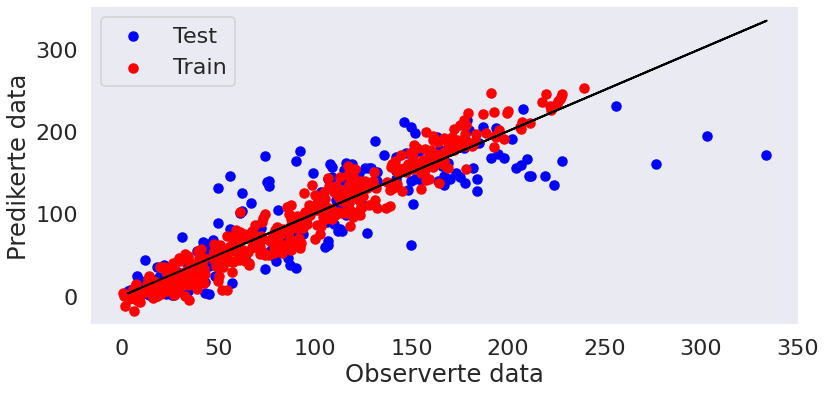

In [58]:
y_train_pred = scalar.inverse_transform( rf.predict(x_train).reshape(-1,1) )
y_test_pred = scalar.inverse_transform( rf.predict(x_test).reshape(-1,1) )

positive_test = y_test_pred > 0
positive_train = y_train_pred > 0

y_test_actual  = scalar.inverse_transform( y_test )
y_train_actual = scalar.inverse_transform( y_train )

rescaled_ytest = scalar.inverse_transform(y_test)
rescaled_ytrain = scalar.inverse_transform(y_train)

print(np.max( rescaled_ytest) )
print(np.max( rescaled_ytrain) )
#y_test_pred = scalar.inverse_transform( knn_reg.predict(x_test).reshape(-1,1) )

sns.set_context('talk', font_scale=1.350)
f, ax = plt.subplots(figsize=(12, 6))
#axt = ax.twinx()
ax.scatter(y_test_actual[positive_test], y_test_pred[positive_test], color='blue')
ax.scatter(y_train_pred[positive_train], y_train_actual[positive_train], color = 'red')
ax.legend(['Test','Train'], loc='upper left')

ax.plot(y_test_actual, y_test_actual, '-k', linewidth = 2)
#ax.set_ylim(0, 2)
#ax.set_xlim(0, 10000)

ax.set_xlabel("Observerte data")
ax.set_ylabel("Predikerte data")
ax.set(frame_on=True)
f.tight_layout()
f.savefig('/home/abay/Desktop/DataScienceTutor/sykk/images/station_496_end_no_trips_prediction.eps')

# Ensemble regression

In [59]:
# importing utility modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb

 
# importing bagging module
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Splitting between train data into training and validation dataset
x, y = station_494_end[['temprature', 'precipitation', 'windspeed']].values, station_494_end['n_trips'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0, shuffle=True)
#print(x_train.shape)

x_train = station_494_end.loc[0:530+100323, ['temprature', 'precipitation', 'windspeed']].values
x_test  = station_494_end.loc[530+100323:, ['temprature', 'precipitation', 'windspeed']].values


y_train = station_494_end.loc[0:530+100323, 'n_trips'].values#.values
#print(y_train)
y_test = station_494_end.loc[530+100323:, 'n_trips'].values

y_train = scalar.fit_transform(y_train.reshape(-1,1))
y_test  = scalar.fit_transform(y_test.reshape(-1,1))


# initializing the bagging model using XGboost as base model with default parameters
ensemble = BaggingRegressor(base_estimator=RandomForestRegressor())
 
# training model
ensemble.fit(x_train, y_train)
 
# predicting the output on the test dataset

 
# printing the root mean squared error between real value and predicted value
#print(mean_squared_error(y_train, pred))

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingRegressor(base_estimator=RandomForestRegressor())

In [60]:
predict = ensemble.predict(x_test)
r2_score(predict, y_test)

0.7583779655271348

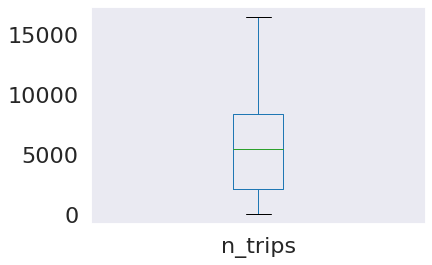

In [61]:
# Check the outliers using boxplot 
def plot_boxplot(df, feature):
    for ft in feature:
        df.boxplot(column=[ft])
        plt.grid(False)
        plt.show()

feature = ['n_trips']
plot_boxplot(df_clean_tot, feature)

In [62]:
capa_df = pd.read_csv('station_status.csv')
capa_df.head()

,Unnamed: 0,station_id,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_docks_available
0,0,2334,1,1,1,1649709677,2,10
1,1,2333,1,1,1,1649709677,2,13
2,2,2332,1,1,1,1649709677,1,11
3,3,2330,1,1,1,1649709677,8,7
4,4,2329,1,1,1,1649709677,0,15


# Artificial neural network 

In [63]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    
def ann_model():
    # Initialising the ANN
    reg = Sequential()

    # Adding the input layer and the first hidden layer
    reg.add(Dense(units = 50, activation='relu', input_dim = 3))

    # Adding the second hidden layer
    reg.add(Dense(units=35,activation='relu'))

    # Adding the third hidden layer
    reg.add(Dense(units=50, activation='relu'))
    # Adding the output layer
    reg.add(Dense(units = 1))

    # Compiling the ANN
    reg.compile(loss = root_mean_squared_error, optimizer='Adamax')

    # Fitting the ANN to the Training set
    #reg.fit(x_train, y_train, validation_split=0.20, batch_size = 12, epochs=8, verbose=0)
    return reg
model = ann_model()

model.fit(x_train, y_train, validation_split=0.20, batch_size = 6, epochs=10, verbose=0)
ann_pred = model.predict(x_test)

# Predict initial and return number of trips per each station

In [64]:
# Number of returning trips 
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
def n_returntrips_per_station(df, weather, month):    
    ens = BaggingRegressor(base_estimator=SVR())
    knn = KNeighborsRegressor(n_neighbors = 5)# fit the model using the training data and training targets

    top_50 = df.groupby('end_station_id')['n_trips'].mean().reset_index().sort_values('n_trips', ascending = False)
    station_id = set(top_50.end_station_id.values)

    test_score = []
    train_score = []
    predict_each_station = []
    for station in station_id:
        # Clean the data for each return station
        index_station = index_storage(df[df['end_station_id'] == station], feature)
        df_clean_end  = remove_outliers(df[df['end_station_id'] == station], index_station)#
        df_clean_end['month'] = df_clean_end['year_day'].dt.month
        leng = int(df_clean_end.shape[0]*0.8)
        if (leng > 365) & (df_clean_end['n_trips'].mean() > 15) & ('2022-02-28' == df_clean_end['year_day']).any():
            index_ = df_clean_end.index
            start_index = index_[0]
            
            #x = df_clean_end[['temprature', 'precipitation', 'windspeed']].values
            #y = df_clean_end['n_trips'].values        
            #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        
            x_train = df_clean_end.loc[0:start_index+leng, ['temprature', 'precipitation', 'windspeed']].values
            x_test  = df_clean_end.loc[leng+start_index:, ['temprature', 'precipitation', 'windspeed']].values
        
            y_train = df_clean_end.loc[0:leng+start_index, 'n_trips'].values#.values
            y_test  = df_clean_end.loc[leng+start_index:,  'n_trips'].values  
        
            #x_train = scalar.fit_transform(x_train)
            #x_test = scalar.fit_transform(x_test)
        
            y_train = scalar.fit_transform(y_train.reshape(-1, 1))
            y_test  = scalar.fit_transform(y_test.reshape(-1, 1))
        
            ens.fit(x_train, y_train);        
            predict_test = ens.predict(x_test)         
            predict_train = ens.predict(x_train)
            forcast = ens.predict(weather)
    
            if round(r2_score(predict_test, y_test), 2) < .25:
                knn.fit(x_train, y_train)
                preict_test = knn.predict(x_test) 
                predict_train = knn.predict(x_train)
                forcast = knn.predict(weather)
        
            test_score.append([station, r2_score(predict_test, y_test)])
            train_score.append([station, r2_score(predict_train, y_train)])
            
            max_trip = df_clean_end.groupby('month')['n_trips'].max().reset_index()
            min_trip = df_clean_end.groupby('month')['n_trips'].min().reset_index()
            mean_trip = df_clean_end.groupby('month')['n_trips'].mean().reset_index()
            
            if (forcast < min_trip.loc[month, 'n_trips']) | (forcast > max_trip.loc[month, 'n_trips']):
                forcast = scalar.fit_transform(mean_trip.loc[month, 'n_trips'].reshape(-1,1))
                
            
            predict_each_station.append([station, int(scalar.inverse_transform(forcast))])
        predict_ntrips = pd.DataFrame(predict_each_station, columns=['station_id', 'n_trips'])
        predict_ntrips.rename(columns={'n_trips':'return_station'}, inplace = True)
    
    return predict_ntrips

In [65]:
# NUmber of initial trips per each station
def n_initiatedtrips_per_station(df, weather, month):    
    ens = BaggingRegressor(base_estimator=SVR())
    knn = KNeighborsRegressor(n_neighbors = 5)# fit the model using the training data and training targets

    top_50 = df.groupby('start_station_id')['n_trips'].mean().reset_index().sort_values('n_trips', ascending = False)
    station_id = set(top_50.start_station_id.values)

    test_score = []
    train_score = []
    predict_each_station = []
    for station in station_id:
        # Clean the data for each return station
        index_station = index_storage(df[df['start_station_id'] == station], feature)
        df_clean_start  = remove_outliers(df[df['start_station_id'] == station], index_station)#
        df_clean_start['month'] = df_clean_start['year_day'].dt.month
        leng = int(df_clean_start.shape[0]*0.8)
        if (leng > 365) & (df_clean_start['n_trips'].mean() > 15) & ('2022-02-28' == df_clean_start['year_day']).any():
            index_ = df_clean_start.index
            start_index = index_[0]
            
            #x = df_clean_start[['temprature', 'precipitation', 'windspeed']].values
            #y = df_clean_start['n_trips'].values        
            #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        
            x_train = df_clean_start.loc[0:start_index+leng, ['temprature', 'precipitation', 'windspeed']].values
            x_test  = df_clean_start.loc[leng+start_index:, ['temprature', 'precipitation', 'windspeed']].values
        
            y_train = df_clean_start.loc[0:leng+start_index, 'n_trips'].values#.values
            y_test  = df_clean_start.loc[leng+start_index:,  'n_trips'].values  
        
            #x_train = scalar.fit_transform(x_train)
            #x_test = scalar.fit_transform(x_test)
        
            y_train = scalar.fit_transform(y_train.reshape(-1, 1))
            y_test  = scalar.fit_transform(y_test.reshape(-1, 1))
        
            ens.fit(x_train, y_train);        
            predict_test = ens.predict(x_test)         
            predict_train = ens.predict(x_train)
            forcast = ens.predict(weather)
    
            if round(r2_score(predict_test, y_test), 2) < .25:
                knn.fit(x_train, y_train)
                preict_test = knn.predict(x_test) 
                predict_train = knn.predict(x_train)
                forcast = knn.predict(weather)
        
            test_score.append([station, r2_score(predict_test, y_test)])
            train_score.append([station, r2_score(predict_train, y_train)])
            
            max_trip = df_clean_start.groupby('month')['n_trips'].max().reset_index()
            min_trip = df_clean_start.groupby('month')['n_trips'].min().reset_index()
            mean_trip = df_clean_start.groupby('month')['n_trips'].mean().reset_index()
            
            if (forcast < min_trip.loc[month, 'n_trips']) | (forcast > max_trip.loc[month, 'n_trips']):
                forcast = scalar.fit_transform(mean_trip.loc[month, 'n_trips'].reshape(-1,1))
                
            
            predict_each_station.append([station, int(scalar.inverse_transform(forcast))])
        predict_ntrips = pd.DataFrame(predict_each_station, columns=['station_id', 'n_trips'])
        predict_ntrips.rename(columns={'n_trips':'start_station'}, inplace = True)
    return predict_ntrips

# Get number of return trips for a given weather


In [66]:
return_trips = n_returntrips_per_station(df_trip_end_station, np.array([[8.780e+00,  1.000e-02,  1.360e+00]]), 4)

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

In [67]:
#return_trips = pd.DataFrame(predict_each_station, columns=['station_id', 'n_trips'])
return_trips.head()

,station_id,return_station
0,514,32
1,519,38
2,521,47
3,522,25
4,523,55


## Get number of initial trips per each station for a given weather data


In [68]:
initiated_trinps = n_initiatedtrips_per_station(df_trip_station, np.array([[6.780e+00,  1.000e-02,  1.360e+00]]), 4)

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/abay/py_36_env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

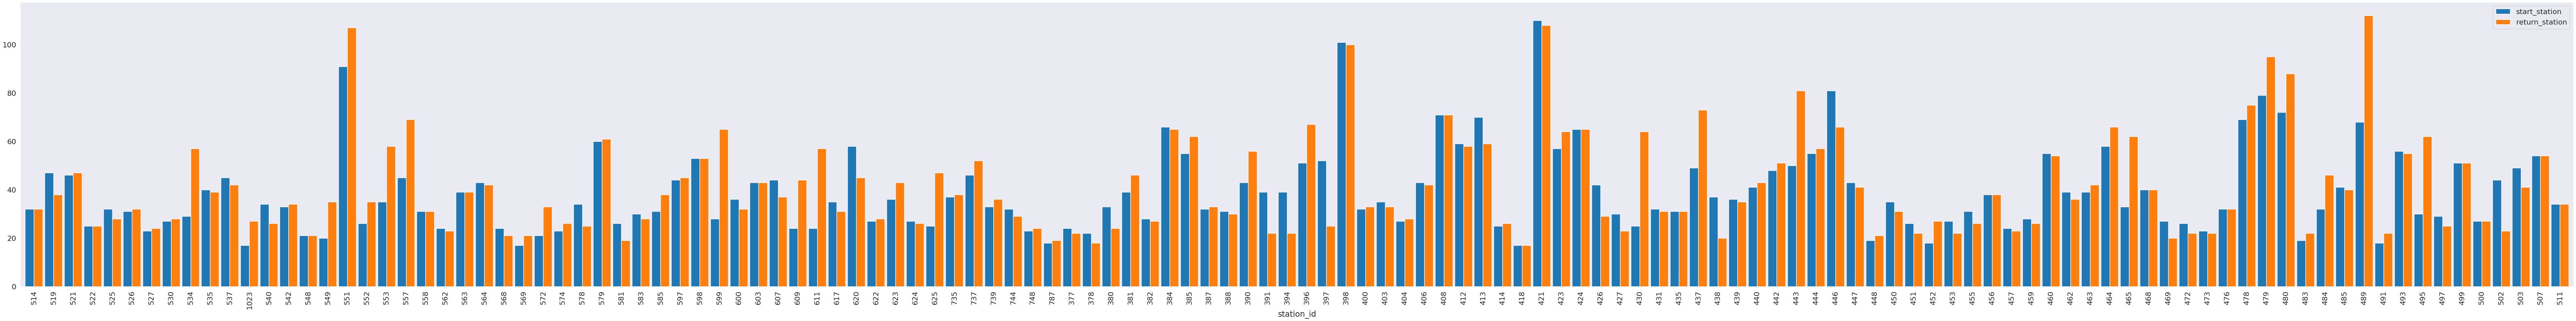

In [69]:
# Number of initial and return trips visualization

predicted_trips = pd.merge(initiated_trinps, return_trips, on='station_id', how='inner')
predicted_trips.tail(60)
ax=predicted_trips.plot(x='station_id', y=['start_station', 'return_station'], kind='bar', width=0.9, figsize=(140, 16))

In [70]:
# Get the difference beteween initial and return number of trips per station

predicted_trips['diff'] = predicted_trips['start_station'] - predicted_trips['return_station']
predicted_trips.head()

,station_id,start_station,return_station,diff
0,514,32,32,0
1,519,47,38,9
2,521,46,47,-1
3,522,25,25,0
4,525,32,28,4


In [71]:
#train_score
#test_score_above = []
#for i in range(len(test_score)):
#    if round(test_score[i][1], 2) >= 0.25:
#        test_score_above.append([test_score[i][0], round(test_score[i][1], 2)])
#print(len(test_score_above))
#print(test_score_above)

# OPtimal moving strategy 

In [72]:
# Read the Oslobysykkel data
sykkl_data = pd.read_csv('sykkle_data.csv')

In [73]:
# Get latitude and longitude positions of each station
sykkle_data = sykkl_data[['start_station_id', 'start_station_description', 'start_station_latitude', 'start_station_longitude']]
sykkle_data = sykkle_data.drop_duplicates(subset ="start_station_id")
sykkle_data.head()

,start_station_id,start_station_description,start_station_latitude,start_station_longitude
0,423,nærmest rundkjøringen,59.920335,10.760804
1,412,langs Torggata,59.917866,10.754898
2,407,langs Kierschovs gate,59.937743,10.751648
3,579,ved Sporveisgata,59.924732,10.724628
4,525,ved Bentsenbrua,59.937205,10.760581


In [74]:
# Get the stations status

station_status = pd.read_csv('station_status.csv')
station_status['station_capacity'] = station_status['num_bikes_available'] + station_status['num_docks_available']
station_status = station_status[['station_id', 'num_bikes_available', 'num_docks_available', 'station_capacity']]
station_status.head()

,station_id,num_bikes_available,num_docks_available,station_capacity
0,2334,2,10,12
1,2333,2,13,15
2,2332,1,11,12
3,2330,8,7,15
4,2329,0,15,15


In [75]:
# Merge station status with the predicted number of trips 
merged = pd.merge(station_status, predicted_trips, on = 'station_id', how = 'left')
merged.fillna(0, inplace=True)
merged.head()

,station_id,num_bikes_available,num_docks_available,station_capacity,start_station,return_station,diff
0,2334,2,10,12,0.0,0.0,0.0
1,2333,2,13,15,0.0,0.0,0.0
2,2332,1,11,12,0.0,0.0,0.0
3,2330,8,7,15,0.0,0.0,0.0
4,2329,0,15,15,0.0,0.0,0.0


In [76]:
#station_id_list = merged.station_id.tolist()
 
#sykkl_data = sykkle_data[sykkl_data['start_station_id'].isin(station_id_list)]
#sykkl_data.dropna(inplace=True)
#sykkl_data.head()

In [77]:
merged = pd.merge(merged, sykkle_data, left_on='station_id', right_on='start_station_id', how = 'inner')
merged.head()

,station_id,num_bikes_available,num_docks_available,station_capacity,start_station,return_station,diff,start_station_id,start_station_description,start_station_latitude,start_station_longitude
0,2332,1,11,12,0.0,0.0,0.0,2332,Hjørnet av Hausmannsgata and Storgata,59.916296,10.757377
1,2330,8,7,15,0.0,0.0,0.0,2330,Krysset Skippergata Storgata,59.913233,10.749959
2,2329,0,15,15,0.0,0.0,0.0,2329,mellom bygningene ved Via Vika,59.912713,10.727171
3,2328,7,14,21,0.0,0.0,0.0,2328,Mellom Oslo City og The Hub hotel,59.912522,10.750910
4,2315,3,15,18,0.0,0.0,0.0,2315,utenfor Bjørvika visningssenter,59.906920,10.760312


## A method to calculate the distance fom each station

In [78]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
# driver code
#lat1 = 53.32055555555556
#lat2 = 53.31861111111111
#lon1 = -1.7297222222222221
#lon2 =  -1.6997222222222223
#print(distance(lat1, lat2, lon1, lon2), "K.M")

# Moving the bikes  

In [79]:
#diff = (predicted_trips.start_station - predicted_trips.return_station)
condition_1 = merged['diff'] >= merged.station_capacity*0.1
condition_2 = merged['num_bikes_available'] < merged['station_capacity']*0.5
condition_3 = merged.start_station > 0

index_to   = (condition_1 | condition_2) & condition_3
index_from = merged.num_bikes_available >= merged.station_capacity*0.75

move_bikes_to = merged.loc[index_to, :]
# topten_move_to = move_bikes_to.head(10)

move_bikes_from = merged.loc[index_from, :]
move_bikes_from.sort_values('num_docks_available', ascending=False).reset_index()

list_bikes_from   = move_bikes_from.num_bikes_available.to_list()
list_dock_from    = move_bikes_from.station_capacity.to_list()
list_station_from = move_bikes_from.station_id.to_list()

list_bikes_to   = move_bikes_to.num_bikes_available.to_list()
list_dock_to    = move_bikes_to.station_capacity.to_list()
list_station_to = move_bikes_to.station_id.to_list()


list_latitude_to  = move_bikes_to.start_station_latitude.to_list()
list_longitude_to = move_bikes_to.start_station_longitude.to_list()

list_latitude_from  = move_bikes_from.start_station_latitude.to_list()
list_longitude_from = move_bikes_from.start_station_longitude.to_list()

def getKey(item):
    return item[3]



for j in range(0, len(list_bikes_to)):
    if list_bikes_to[j] < list_dock_to[j]*0.75:
        #print('True')
        # station and distance from other stations
        station_distance = [[list_bikes_from[k], list_dock_from[k], list_station_from[k], distance(list_latitude_to[j], list_latitude_from[k], list_longitude_to[j], list_longitude_from[k])] for k in range(0, len(list_station_from))]
        station_distance = sorted(station_distance, key=getKey)
        #print(station_distance)
        
        for i in range(0, len(list_bikes_from)):
            #print('Yes')
            if station_distance[i][0] > station_distance[i][1]*0.75:
                #print('Indeed')
                moved_amount = station_distance[i][0]*0.3 # 30% of the bikes
                list_bikes_to[j] = list_bikes_to[j] + moved_amount
                #print(list_bikes_to[j])
                
                station_distance[i][0] = station_distance[i][0] - moved_amount
                if list_bikes_to[j] > list_dock_to[j]:
                    #print('yes it is above ')
                    extra_amount = (list_bikes_to[j]-list_dock_to[j])
                    list_bikes_to[j] = list_bikes_to[j] - extra_amount
                    
                    station_distance[i][0] = station_distance[i][0] + extra_amount
                    moved_amount = moved_amount - extra_amount
                    #print(moved_amount)
                    #print(list_bikes_to[j])

                    #break
            #else:
                #continue
                #print('MOve', round(moved_amount), 'to')
                if moved_amount >= 1:
                    print('Flytte {}  sykler fra stasjon {}  til stasjon {}'.format(round(moved_amount), station_distance[i][2], list_station_to[j])  )
      

Flytte 3  sykler fra stasjon 527  til stasjon 1023
Flytte 4  sykler fra stasjon 2308  til stasjon 1023
Flytte 3  sykler fra stasjon 412  til stasjon 1023
Flytte 3  sykler fra stasjon 574  til stasjon 1023
Flytte 3  sykler fra stasjon 527  til stasjon 787
Flytte 4  sykler fra stasjon 2308  til stasjon 787
Flytte 3  sykler fra stasjon 574  til stasjon 787
Flytte 2  sykler fra stasjon 412  til stasjon 787
Flytte 5  sykler fra stasjon 398  til stasjon 624
Flytte 4  sykler fra stasjon 458  til stasjon 624
Flytte 2  sykler fra stasjon 439  til stasjon 624
Flytte 2  sykler fra stasjon 382  til stasjon 622
Flytte 2  sykler fra stasjon 473  til stasjon 622
Flytte 4  sykler fra stasjon 470  til stasjon 622
Flytte 6  sykler fra stasjon 505  til stasjon 622
Flytte 3  sykler fra stasjon 388  til stasjon 622
Flytte 2  sykler fra stasjon 382  til stasjon 620
Flytte 4  sykler fra stasjon 470  til stasjon 620
Flytte 2  sykler fra stasjon 473  til stasjon 620
Flytte 6  sykler fra stasjon 505  til stasjo